In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import random 
import os 

from work import handler
from work import casestudy
from work import storm_tracker

from work.plots.hist import simple_hist
from work.transect import add_transects_with_aligned_boxes,make_mask_box

settings_path = 'settings/sam3d.yaml'

# import matplotlib.cm as cm
# from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
# import glob
# import intake
# import dask
# import functools
# import pandas as pd
# dask.config.set({"array.slicing.split_large_chunks": True}) 
import cartopy.crs as ccrs
import cartopy.feature as cf
# import cmocean
# # !pip install easygems
# import tqdm
# import scipy
# import datetime as dt 
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
# from funcs import *


hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

Data loaded from /homedata/mcarenso/shear/SAM3d_Tropics/var_id_days_i_t.json
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 3.80 seconds


In [2]:
test = xr.open_dataset("/bdd/DYAMOND/SAM-4km/OUT_3D/DYAMOND_9216x4608x74_7.5s_4km_4608_0000001440_PP.nc")
z_targets = [300, 2000, 4000, 8000, 12000]
z_indices = [np.abs(test.z.values - target).argmin() for target in z_targets]
z_all = test.z.values.copy()
z_tropo = z_all[:np.abs(test.z.values - 15000).argmin()+1] # L'alitude de la Troposphère est à 15000m à l'équateur max non ? utiliser les pressions ? 
print("z_shear index", z_indices)
print("len z_tropo", len(z_tropo))

p_targets = [975, 800, 600, 350, 200] #mbar or hPa
p_indices = [np.abs(test.p.values-target).argmin() for target in p_targets] ## Est ce que je dois être plus flexible sur l'extraction des coordonnées de pression ? 
                                                                            ## Je peux le faire en extrayant les vents puis interpolant sur ma grille régulière ! 
p_all = test.p.values.copy()
p_tropo = p_all[:np.abs(test.z.values - 15000).argmin()+1]
print("p       index", p_indices)
test.close()

z_shear index [6, 22, 29, 37, 45]
len z_tropo 52
p       index [6, 22, 30, 38, 45]


In [3]:
def add_gridlines(ax):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'gray'}
    gl.ylabel_style = {'size': 10, 'color': 'gray'}
    gl.xlocator = plt.MaxNLocator(integer=True)
    gl.ylocator = plt.MaxNLocator(integer=True)

In [4]:
duration_min = 6 #12
surfmaxkm2_min = 25000 #50000
region_latmin, region_latmax, region_lonmin, region_lonmax = 4, 25, -18, 25
filename_save = f"save_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
save_storms_path = os.path.join(os.path.join(st.settings["DIR_DATA_OUT"], cs.name), filename_save)

# os.remove(save_storms_path)

if not os.path.exists(save_storms_path): 
    storms = xr.open_dataset(st.file_storms)
    
    # Filter based on duration and surface area
    ### HIGH PROPAGATION ####
    storms = storms.where(storms.INT_velocityAvg > 3, drop=True)  # 1min
    storms = storms.where(storms.INT_distance > 500, drop=True)  # 1min

    # ### LOW PROPAGATION ####
    # storms = storms.where(storms.INT_velocityAvg <= 3, drop=True)  # 1min
    # storms = storms.where(storms.INT_distance <= 500, drop=True)  # 1min
    
    # Filter based on duration and surface area
    storms = storms.where(storms.INT_duration > duration_min, drop=True)  # 1min
    storms = storms.where(storms.INT_surfmaxkm2_241K > surfmaxkm2_min, drop=True)
    
    # Apply latitude and longitude constraints
    storms = storms.where((storms.INT_latmin >= region_latmin) & (storms.INT_latmax <= region_latmax), drop=True)
    if region_lonmin>=0 : 
        storms = storms.where((storms.INT_lonmin >= region_lonmin) & (storms.INT_lonmax <= region_lonmax), drop=True)
    elif region_lonmin<0:
        storms = storms.where((storms.INT_lonmin >= 360+region_lonmin) | (storms.INT_lonmin <= region_lonmax), drop=True)
    
    # Save the filtered storms data
    storms.to_netcdf(save_storms_path)
    storms.close()
else: 
    storms = xr.open_dataset(save_storms_path)

In [6]:
## FileTracking is ft
ft = storms[[ 
    "INT_UTC_timeInit", "INT_UTC_timeEnd", "INT_duration", "INT_surfcumkm2_241K", "INT_velocityAvg", "INT_surfmaxkm2_241K", ## General characteristics
    "LC_lon", "LC_lat", "LC_UTC_time", "LC_ecc_241K", "LC_orientation_241K", "LC_surfkm2_241K", "LC_tb_90th", "LC_velocity" ## General characteristics
             ]]

all_storms = xr.open_dataset(st.file_storms)
## Valid times for 3d var are %6==0 
t=0
ft_3d = ft.sel(time=ft.time[(ft.time - st.i_t_start + cs.settings["TIME_RANGE"][0]) % 6 == 0])
large_scale_frame_size = 3


while t<1: 
    iDCS = random.choice(all_storms.DCS_number.values)
    iDCS= 264574 #240775 #194862 #240640
    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(all_storms, iDCS)
    extents, slices_lon, slices_lat = st.get_extents_slices(lons_3d, lats_3d, large_scale_frame_size = large_scale_frame_size)
    full_extent, full_slice_lon, full_slice_lat = st.get_full_extent_slice(lons_3d, lats_3d, large_scale_frame_size = large_scale_frame_size)

    times_3d_conv = [time for time in times_3d if time <= time_smax + st.settings["TIME_RANGE"][0]]
    t = len(times_3d_conv)

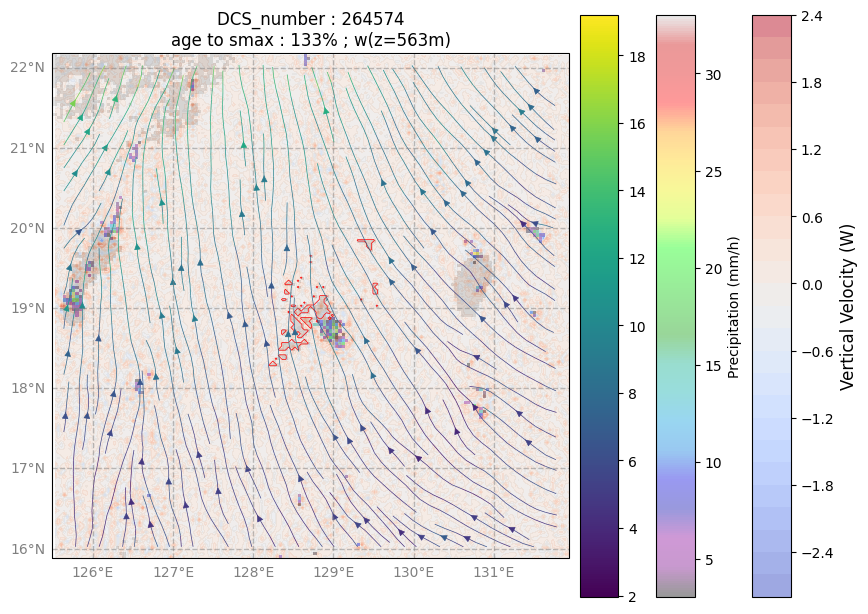

In [7]:
from shapely.geometry import Point, Polygon

## Get systemes moment frame 
i = 2
i_z_plot = 10

# bool_fixed_frame = True
# if ~bool_fixed_frame : 
#     slice_lat, slice_lon, extent = slices_lat[i], slices_lon[i], extents[i]
# else : 

slice_lat, slice_lon, extent = full_slice_lat, full_slice_lon, full_extent
transects = [((lats[0], lons[0]), (lats[i_smax], lons[i_smax]))] ## indeed ill defined mf putting y,x instead of x,y...

projection = ccrs.PlateCarree(central_longitude = 0)

## Instantiate plot
figsize_ratio = 4/large_scale_frame_size
fig, ax = plt.subplots(
figsize=(figsize_ratio*(extent[1]-extent[0]), figsize_ratio*(extent[3]-extent[2])),
            subplot_kw={"projection": projection},
            constrained_layout=True) 

ax.set_extent(extent, crs=ccrs.PlateCarree())
add_gridlines(ax)

## Load data
le_dico_long = {"latitude" : slice_lat, "longitude" : slice_lon}
le_dico_court = {    "lat" : slice_lat,       "lon" : slice_lon}

u = hdlr.load_var(cs, "U", times_3d[i], z_idx = "L'altitude de la troposphère", sel_dict = le_dico_court).U[0]
v = hdlr.load_var(cs, "V", times_3d[i], z_idx = "L'altitude de la troposphère", sel_dict = le_dico_court).V[0]  
w = hdlr.load_var(cs, "W", times_3d[i], z_idx = "L'altitude de la troposphère", sel_dict = le_dico_court).W[0]
qi = hdlr.load_var(cs, "QI", times_3d[i], z_idx = "L'altitude de la troposphère", sel_dict = le_dico_court).QI[0]

### BIG TRANSECT #####
box_width = 0.2
# add_transects_with_aligned_boxes(ax, transects, width=box_width, color='r', linewidth=1, linestyle='--')  # Draw the transects on the map
n_bins = 40
u_transect = np.full(fill_value = float(0), shape=(len(z_tropo), n_bins))
v_transect = np.full(fill_value = float(0), shape=(len(z_tropo), n_bins))
w_transect = np.full(fill_value = float(0), shape=(len(z_tropo), n_bins))
qi_transect = np.full(fill_value = float(0), shape=(len(z_tropo), n_bins))

# for transect in transects: #trasect = transects[0]
#     # start, end point of (lat, lon)
#     start_transect, end_transect = transect[0], transect[1]
#     ##lon, lat centers along the transect
#     bin_sides = np.linspace(start_transect, end_transect, n_bins+1) 
    
#     for i_bin, bin_box in enumerate(zip(bin_sides[:-1], bin_sides[1:])): 
#         bin_box_corners = make_mask_box(bin_box[0], bin_box[1], box_width)

#         bin_box_lats, bin_box_lons = zip(*bin_box_corners)
#         ax.plot(bin_box_lons, bin_box_lats, color='r', linewidth=1, linestyle='--',transform=ccrs.PlateCarree(), label=bin_box_corners[0][0])
#         # Create a polygon from the corners
#         polygon = Polygon(bin_box_corners)

#         lat_grid, lon_grid = np.meshgrid(u['lat'].values, u['lon'].values, indexing='ij')
#         mask = np.zeros(lat_grid.shape, dtype=bool)
#         for i_lat in range(lat_grid.shape[0]):
#             for j_lat in range(lat_grid.shape[1]):
#                 point = Point(lat_grid[i_lat, j_lat], lon_grid[i_lat, j_lat])
#                 if polygon.contains(point):
#                     mask[i_lat, j_lat] = True
#         if not np.all(~mask): 
#             u_box, v_box, w_box, qi_box = u.where(mask).mean(dim=['lat', 'lon']), v.where(mask).mean(dim=['lat', 'lon']), w.where(mask).mean(dim=['lat', 'lon']), qi.where(mask).mean(dim=['lat', 'lon'])
#             u_transect[:, i_bin] = u_box
#             v_transect[:, i_bin] = v_box
#             w_transect[:, i_bin] = w_box
#             qi_transect[:, i_bin] = qi_box

### ARROW PROPAGATION MATURATION
lon_smax, lat_smax = lons[i_smax], lats[i_smax]
lon_propa, lat_propa = lon_smax - lons[0], lat_smax - lats[0]
ax.quiver(lons[0], lats[0], lon_propa, lat_propa, scale=1, angles='xy', scale_units='xy')


### W ###
# Assuming 'w' is already loaded and has the appropriate dimensions
# I'll use 'lat' and 'lon' from the coordinates of 'w' for plotting
lat = w['lat'].values
lon = w['lon'].values
lon_grid, lat_grid = np.meshgrid(lon, lat) #, indexing='ij'
# filtered_w = np.where(w.values[i_z_plot] < 0.5, np.nan, w.values[i_z_plot])
contour_w = ax.contourf(
    lon_grid, lat_grid, w.values[i_z_plot],  # w.values[i_z_plot]
    cmap='coolwarm',  # Color map for visualization
    levels=30,         # Number of contour levels
    alpha=0.5,          # Transparency level
    # transform=projection, 
    # extent=extent
)
cbar = plt.colorbar(contour_w, ax=ax, orientation='vertical', shrink=0.7, pad=0.02, aspect=15)
cbar.set_label('Vertical Velocity (W)', fontsize=12)

##### PREC #####
prec_cmap =  plt.get_cmap("nipy_spectral")
prec = hdlr.load_var(cs, "Prec", times_3d[i], sel_dict = le_dico_court)
prec_masked = np.ma.masked_less_equal(prec, 3)

im_prec = ax.pcolormesh(
    lon_grid,
    lat_grid,
    prec_masked,
    cmap=prec_cmap,
    # transform=projection,
    # extent=extent,
    alpha=0.4
)

cbar = plt.colorbar(im_prec, ax=ax, orientation='vertical', shrink=0.7, pad=0.02, aspect=15)
cbar.set_label('Precipitation (mm/h)')  # Customize the label as needed

colors = [(1, 1, 1, 0), (0.8, 0.8, 0.8, 0.3), (0.5, 0.5, 0.5, 1)]  # RGBA for light grey to very light grey (with transparency)
colors = [(1, 1, 1, 0), (0.0, 0.0, 0.0, 0.3), (0.5, 0.5, 0.5, 1)]  # RGBA for light grey to very light grey (with transparency)
cmap = LinearSegmentedColormap.from_list("light_grey_scale", colors)

##### CLOUD MASK + CONTOUR ######
seg = hdlr.load_seg(times_3d[i], sel_dict = le_dico_long)[0] #.sel(le_dico_long)
nan_mask = np.isnan(seg)
output = np.full_like(seg, 0.5, dtype = float)
output[nan_mask] = 0
output[seg == iDCS] = 1
ax.contour(output, levels=[0.75], colors='red', linewidths=0.5, linestyles='solid', extent = extent)
output[seg == iDCS] = 0.5
im_seg = ax.pcolormesh(
    lon_grid,
    lat_grid,
    output,
    cmap=cmap,
    norm=mcolors.Normalize(vmin=0, vmax=1),
    # transform=projection,
    # extent=extent,
    alpha=0.1,
)

#### U & V #####
lon, lat = u["lon"], v["lat"]
new_lon, new_lat = np.linspace(lon.min(), lon.max(), len(lon)), np.linspace(lat.min(), lat.max(), len(lat))
u_clean = u.interp(lon=new_lon, lat=new_lat)[i_z_plot]
v_clean = v.interp(lon=new_lon, lat=new_lat)[i_z_plot]
lon_grid_regular, lat_grid_regular = np.meshgrid(new_lon, new_lat)
horizontal_wind_magnitude = np.sqrt(u_clean.values**2 + v_clean.values**2)
strm = ax.streamplot(lon_grid_regular, lat_grid_regular, u_clean.values, v_clean.values, color=horizontal_wind_magnitude, cmap = "viridis", linewidth=0.5, density=1.5)
fig.colorbar(strm.lines,  shrink=0.7, pad=0.02, aspect=15)

age_to_smax = int(100*np.round((times_3d[i] - st.settings["TIME_RANGE"][0] - start) / (time_smax - start), 2))

plt.title(f"DCS_number : {iDCS}"+"\n"+"age to smax : "+f"{age_to_smax}%" + f" ; w(z={int(z_tropo[i_z_plot])}m)")
plt.show()

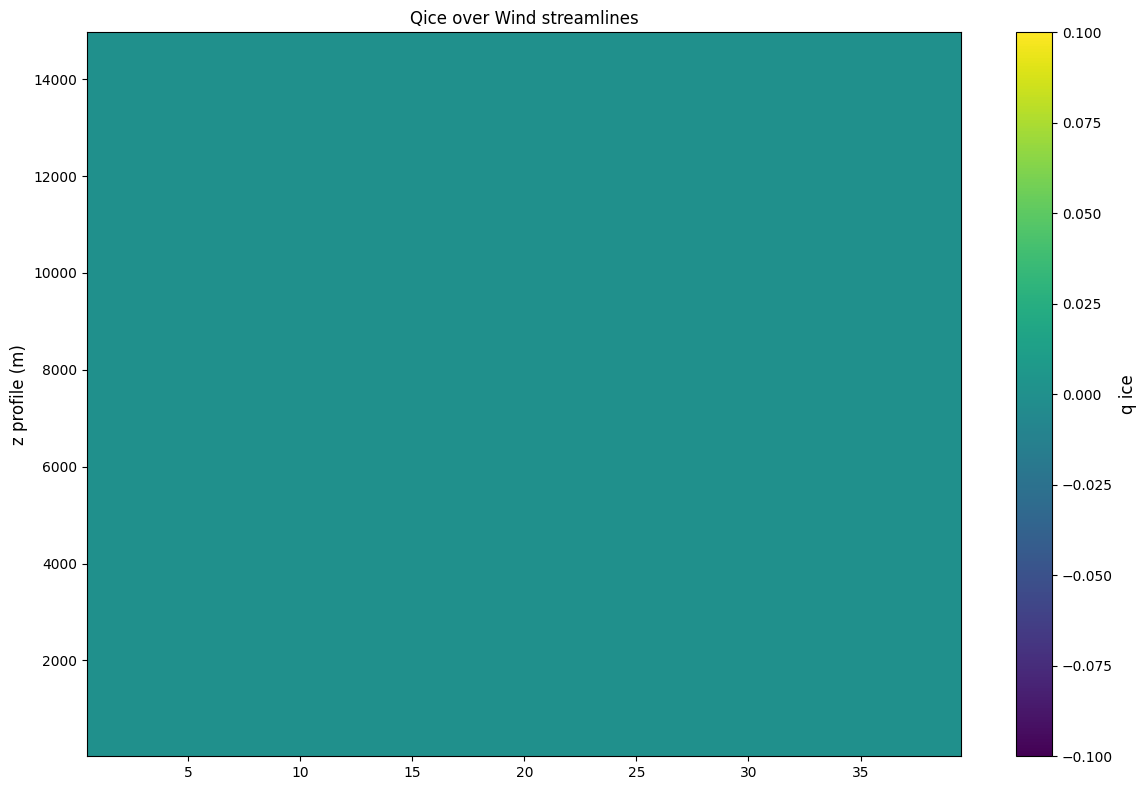

In [52]:
from work.thermo import haversine 
from scipy.interpolate import griddata

x_vals = np.linspace(0.5, n_bins-0.5, n_bins)  # Adjust according to your data
y_vals = np.array(z_tropo)  # Ensure z_all is a NumPy array of actual z-axis values (in meters)

# Original pressure levels and data
original_p_levels = np.array(y_vals)  # Your uneven pressure levels (e.g., in hPa or mb)
new_z_levels = np.linspace(original_p_levels.min(), original_p_levels.max(), num=80)  # Create a regular grid in pressure coordinates

##### DCS MATURATION TOTAL PROPAGATION #####
lon_smax, lat_smax = lons[i_smax], lats[i_smax]
lon_propa, lat_propa = lon_smax - lons[0], lat_smax - lats[0]
lons[0], lats[0], lon_propa, lat_propa #angles='xy', scale_units='xy'

distance_propagation = haversine(lons[0], lats[0], lon_smax, lat_smax)
avg_system_speed = distance_propagation/(i_smax*30*60)
norm_propa = np.sqrt(lon_propa**2 + lat_propa**2) 

u_propa, v_propa = lon_propa/norm_propa, lat_propa/norm_propa

tangeant = u_transect * u_propa + v_transect * v_propa


# Convert your data to an xarray DataArray
ds = xr.Dataset(
    {
        "tangeant": (["z", "x"], tangeant),
        "w_transect": (["z", "x"], w_transect),
        "qi_transect": (["z", "x"], qi_transect)
    },
    coords={
        "z": y_vals,  # Original pressure levels
        "x": x_vals  # Your x-values
    }
)


# Define a regular grid for pressure levels
regular_z_grid = np.linspace(ds.z.min(), ds.z.max(), num=80)

# Interpolate to the regular grid using xarray's built-in interpolation
ds_regular = ds.interp(z=regular_z_grid)

# Extract the interpolated data
tangeant_interpolated = ds_regular['tangeant'].values
w_transect_interpolated = ds_regular['w_transect'].values
qi_transect_interpolated = ds_regular['qi_transect'].values
new_z_levels = ds_regular['z'].values


# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
cax = ax.imshow(qi_transect_interpolated, origin="lower", aspect='auto',
                cmap='viridis',
                extent=[x_vals.min(), x_vals.max(), new_z_levels.min(), new_z_levels.max()])  # Adjusted y-axis

# Add colorbar with label
cbar = fig.colorbar(cax)
cbar.set_label(f'q ice', fontsize=12)  # Replace with the appropriate label

# Add labels and title
ax.set_ylabel('z profile (m)', fontsize=12)  

# Adjust axis limits if necessary
ax.set_xlim([x_vals.min(), x_vals.max()])
ax.set_ylim([new_z_levels.min(), new_z_levels.max()])  # Inverted for pressure coordinate

# ax.pcolormesh(out, cmap='coolwarm')
# cbar = fig.colorbar(ax.pcolormesh(out, cmap='coolwarm'), ax=ax)
# cbar.set_label('Temperature') # Change this label as needed

# wind_norm = np.sqrt(u_transect**2 + v_transect**2 + w_transect**2) # need to interpolate before 
stream = ax.streamplot(x_vals, new_z_levels, tangeant_interpolated, w_transect_interpolated,
                        cmap='hot_r', linewidth=0.4) #color=wind_norm,

# cbar = fig.colorbar(stream.lines, ax=ax)
# cbar.set_label('Wind Speed') # Change this label as needed

# contour = ax.contour(1000 * qr_out, alpha =0.5)
# fig.colorbar(contour, ax=ax)
# cbar.set_label('Rain Content') # Change this label as needed

ax.set_title(f"Qice over Wind streamlines")
# ax.set_xaxis(lon)
plt.tight_layout()
plt.savefig("vertical_transect.png")
plt.show()

Text(0.5, 1.0, 'w')

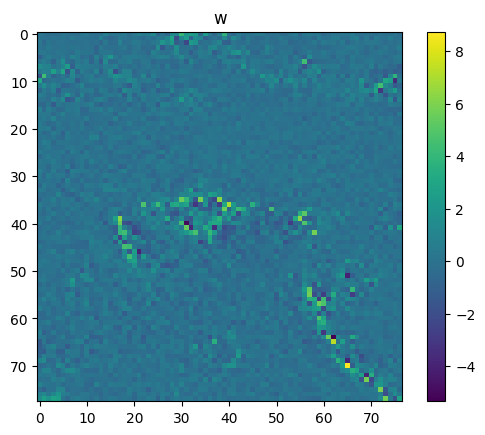

In [46]:
plt.imshow(w[25])
plt.colorbar()
plt.title("w")

## Python scipt dev below

In [6]:
duration_min = 6 #10
surfmaxkm2_min = 10000 #50000 #20000 has 10k elements while 10000 has 29k 
region_latmin, region_latmax, region_lonmin, region_lonmax = -15, 30, -180, 180
filename_save = f"updated_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(os.path.join(st.settings["DIR_DATA_OUT"], cs.name), filename_save)
ft = xr.open_dataset(storms_path)
storms = xr.open_dataset(st.file_storms)

def filter_storm(ft, region_lonmin, region_lonmax, region_latmin, region_latmax, vavg_min=None, vavg_max=None): #, start_date = 
    if vavg_max is None and vavg_min is None : 
        pass
    elif vavg_max is None :
        ft =  ft.where(ft.INT_velocityAvg > vavg_min, drop=True)
    elif vavg_min is None :
        ft = ft.where(ft.INT_velocityAvg < vavg_max, drop=True)
    elif vavg_min is not None and vavg_max is not None : 
        print("you don't understand what you're doing my dear")
    # Apply latitude and longitude constraints
    ft = ft.where((ft.INT_latmin >= region_latmin) & (ft.INT_latmax <= region_latmax), drop=True)
    if region_lonmin>=0 : 
        ft = ft.where((ft.INT_lonmin >= region_lonmin) & (ft.INT_lonmax <= region_lonmax), drop=True)
    elif region_lonmin<0:
        ft = ft.where((ft.INT_lonmin >= 360+region_lonmin) | (ft.INT_lonmin <= region_lonmax), drop=True)
    return ft


ft["INT_max_accumulated_90"] = np.max(ft.LC_accumulated_prec_90th, axis=1)
ft["INT_max_instant_99"] = np.max(ft.LC_instant_prec_99th, axis=1)
ft["INT_max_accumulated_95"] = np.max(ft.LC_accumulated_prec_95th, axis=1)
ft["INT_max_instant_95"] = np.max(ft.LC_instant_prec_95th, axis=1)
ft["INT_sum_total"] = np.sum(ft.LC_total_prec, axis=1)

ft = ft.dropna(dim='DCS_number', subset=['INT_velocityAvg', 'INT_sum_total', 'INT_max_instant_99', 'INT_max_accumulated_90'])

xt =  ft.where((ft.INT_max_accumulated_95)+2*(ft.INT_max_instant_99)>200, drop=True)

## v1 below

0
0
1
2
3
4
5
6
7
8
9
10
0


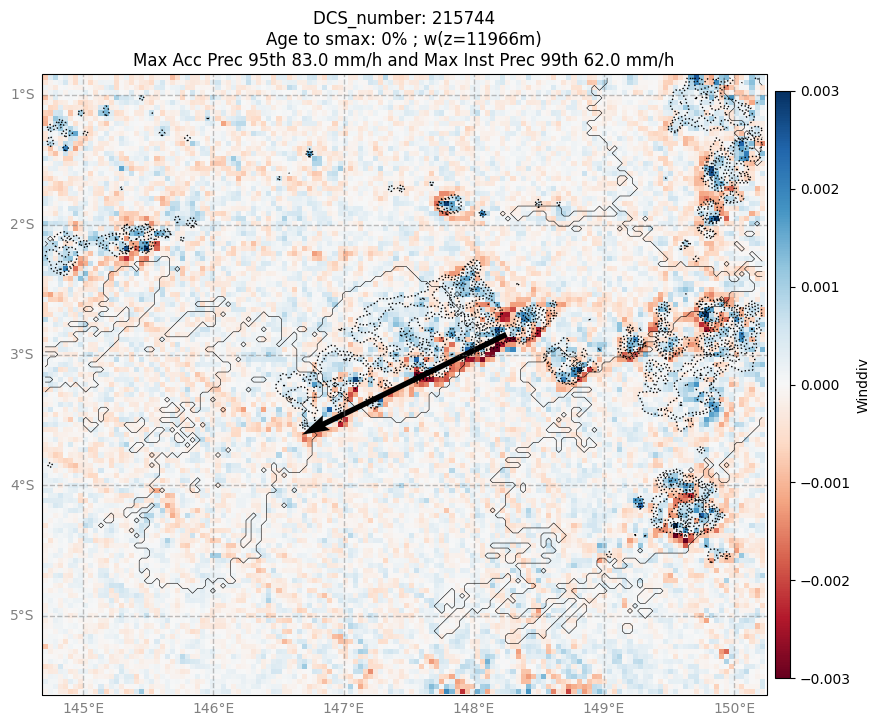

In [7]:
import warnings
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.colors as mcolors
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

lolmdr=0
while lolmdr<1:
    lolmdr+=1
    start = 0
    while start <=245 :
        iDCS = random.choice(xt.DCS_number.values)
        # iDCS = 238454
        large_scale_frame_size = 2
        start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(xt, iDCS)
        full_extent, full_slice_lon, full_slice_lat = st.get_full_extent_slice(lons[:i_smax+1], lats[:i_smax+1], large_scale_frame_size = large_scale_frame_size)
        times_3d_conv = [time for time in times_3d if time <= time_smax + st.settings["TIME_RANGE"][0]]
        t = len(times_3d_conv)

    # Initialize constants and variables
    i_z_plot = 45
    w_minmax = 16  # Adjusted to cover more levels
    w_step = 1  # Step size for 'w' contours
    w_start = 0.8
    slice_lat, slice_lon, extent = full_slice_lat, full_slice_lon, full_extent
    projection = ccrs.PlateCarree(central_longitude=0)
    figsize_ratio = 4 / large_scale_frame_size
    prec_cmap = plt.get_cmap("nipy_spectral")
    colors = [(1, 1, 1, 0), (0.0, 0.0, 0.0, 0.3), (0.5, 0.5, 0.5, 1)]
    cmap = LinearSegmentedColormap.from_list("light_grey_scale", colors)

    # Instantiate the plot
    fig, ax = plt.subplots(figsize=(figsize_ratio * (extent[1] - extent[0]), figsize_ratio * (extent[3] - extent[2])), subplot_kw={"projection": projection})
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    add_gridlines(ax)  # Ensure this function is defined or imported

    # Prepare selection dictionaries
    le_dico_long = {"latitude": slice_lat, "longitude": slice_lon}
    le_dico_court = {"lat": slice_lat, "lon": slice_lon}

    # Load initial data for the first frame
    i = 0
    time_current = times[i]

    seg = hdlr.load_seg(time_current, sel_dict=le_dico_long)[0]
    prec = hdlr.load_var(cs, "Prec", time_current, sel_dict=le_dico_court)
    # prec_masked = np.ma.masked_less_equal(prec, 3)

    # Load PW data
    pw = hdlr.load_var(cs, "PW", time_current, sel_dict=le_dico_court)[0]

    lat = seg['latitude'].values
    lon = seg['longitude'].values
    lon_grid, lat_grid = np.meshgrid(lon, lat)

    U10m = hdlr.load_var(cs, "U10m", time_current, sel_dict=le_dico_court)[0]
    v10m = hdlr.load_var(cs, "V10m", time_current, sel_dict=le_dico_court)[0]
    R = 6371000
    lat_rad = np.radians(lat_grid)
    lon_rad = np.radians(lon_grid)
    dx = R * np.cos(lat_rad) * np.gradient(lon_rad, axis=1)  # Spacing in x-direction (longitude)
    dy = R * np.gradient(lat_rad, axis=0)     
    dU_dx = np.gradient(U10m, axis=1) / dx  # Partial derivative of U with respect to x (longitude)
    dV_dy = np.gradient(v10m, axis=0) / dy  # Partial derivative of V with respect to y (latitude)
    surf_wind_div = dU_dx + dV_dy

    # Plot PW data
    # pw_norm = mcolors.Normalize(vmin=40, vmax=65)
    # pw_cmap = plt.get_cmap('RdBu')
    
    # Plot winddiv data
    wd_cmap = plt.get_cmap('RdBu')
    wd_norm = mcolors.Normalize(vmin = -0.003, vmax= 0.003)
    im_winddiv = ax.pcolormesh(lon_grid, lat_grid, surf_wind_div, cmap=wd_cmap, norm=wd_norm, alpha=1.0)

    # Add colorbar for PW
    cbar_pw = plt.colorbar(im_winddiv, ax=ax, orientation='vertical', pad=0.01, aspect=40, shrink=0.8, label='Winddiv')

    # Initialize cloud mask plot
    nan_mask = np.isnan(seg)
    output = np.full_like(seg, 0.5, dtype=float)
    output[nan_mask] = 0
    output[seg == iDCS] = 1  # Replace iDCS with your actual data
    # im_seg = ax.pcolormesh(lon_grid, lat_grid, output, cmap=cmap, norm=mcolors.Normalize(vmin=0, vmax=1), alpha=0.1)
    contour_output_main = ax.contour(lon_grid, lat_grid, output, levels=[0.75], colors='black', linewidths=[2.0], linestyles='solid')
    contour_output_side = ax.contour(lon_grid, lat_grid, output, levels=[0.25], colors='black', linewidths=[0.4], linestyles='solid')


    # Initialize precipitation contours
    prec_levels = [1, 3, 10, 20, 30, 40, 50]
    contour_prec = ax.contour(lon_grid, lat_grid, prec.values, levels=prec_levels, colors='black', linewidths=0.5, linestyles='dashed')

    max_prec_inst_99 = np.round(xt.sel(DCS_number=iDCS).INT_max_instant_99).values
    xprec = np.ma.masked_less_equal(prec, max_prec_inst_99)
    my_DCS = output==1
    xprec.mask[~my_DCS]=True
    extreme_prec_indices = np.where(xprec.mask == False)
    extreme_lon = lon_grid[extreme_prec_indices]
    extreme_lat = lat_grid[extreme_prec_indices]
    im_xprec = ax.scatter(extreme_lon,  extreme_lat, c='k', marker='x', s=150)

    # Initialize arrow propagation maturation
    lon_smax, lat_smax = lons[i_smax], lats[i_smax]
    lon_propa, lat_propa = lon_smax - lons[0], lat_smax - lats[0]
    quiv = ax.quiver( lons[0], lats[0], lon_propa, lat_propa, scale=1, angles='xy', scale_units='xy')

    # Load initial data for first 3D plot
    first_time_3d = times_3d[0]
    u = hdlr.load_var(cs, "U", first_time_3d, z_idx="L'altitude de la troposphère", sel_dict=le_dico_court).U[0]
    v = hdlr.load_var(cs, "V", first_time_3d, z_idx="L'altitude de la troposphère", sel_dict=le_dico_court).V[0]
    w = hdlr.load_var(cs, "W", first_time_3d, z_idx="L'altitude de la troposphère", sel_dict=le_dico_court).W[0]

    fake_u = xr.DataArray(np.full_like(u, np.nan), coords=u.coords, dims=u.dims)
    fake_v = xr.DataArray(np.full_like(v, np.nan), coords=v.coords, dims=v.dims)
    fake_w = xr.DataArray(np.full_like(w, np.nan), coords=w.coords, dims=w.dims)

    #w levels
    positive_levels = np.arange(w_start, w_minmax + w_step, w_step)
    negative_levels = -positive_levels[::-1]

    contour_w_positive = ax.contour(lon_grid, lat_grid, w.values[i_z_plot], levels=positive_levels, colors='red', linewidths=0.5)
    contour_w_negative = ax.contour( lon_grid, lat_grid, w.values[i_z_plot], levels=negative_levels, colors='blue', linewidths=0.5)

    # Plot wind vectors 'U' and 'V'
    new_lon = np.linspace(lon.min(), lon.max(), len(lon))
    new_lat = np.linspace(lat.min(), lat.max(), len(lat))
    u_clean = u.interp(lon=new_lon, lat=new_lat)[i_z_plot] -  u.interp(lon=new_lon, lat=new_lat)[0] #For now its low level shear instead of wind
    v_clean = v.interp(lon=new_lon, lat=new_lat)[i_z_plot] -  v.interp(lon=new_lon, lat=new_lat)[0]
    lon_grid_regular, lat_grid_regular = np.meshgrid(new_lon, new_lat)
    horizontal_wind_magnitude = np.sqrt(u_clean.values**2 + v_clean.values**2)
    strm = ax.streamplot(lon_grid_regular, lat_grid_regular, u_clean.values, v_clean.values, color=horizontal_wind_magnitude, cmap="viridis", linewidth=0.5, density=1.5)
    age_to_smax = int(100 * np.round((time_current - st.settings["TIME_RANGE"][0] - start) /(time_smax - start), 2))
    title = ax.set_title(f"DCS_number: {iDCS}\nAge to smax: {age_to_smax}%")

    def animate(i):
        global quiv, contour_output_main, contour_output_side, contour_prec, contour_w_positive, contour_w_negative, strm  # Declare as global to modify them
        print(i)
        time_current = times[i]

        # Load data for the current frame
        seg = hdlr.load_seg(time_current, sel_dict=le_dico_long)[0]
        prec = hdlr.load_var(cs, "Prec", time_current, sel_dict=le_dico_court)
        # prec_masked = np.ma.masked_less_equal(prec, 3)
        # pw = hdlr.load_var(cs, "PW", time_current, sel_dict=le_dico_court)[0]

        # Remove and update previous precipitation contours
        for coll in contour_prec.collections:
            coll.remove()
        contour_prec = ax.contour(lon_grid, lat_grid, prec.values, levels=prec_levels, colors='black', linewidths=1, linestyles='dotted')

        ## plot winddiv
        U10m = hdlr.load_var(cs, "U10m", time_current, sel_dict=le_dico_court)[0]
        v10m = hdlr.load_var(cs, "V10m", time_current, sel_dict=le_dico_court)[0]
        R = 6371000
        lat_rad = np.radians(lat_grid)
        lon_rad = np.radians(lon_grid)
        dx = R * np.cos(lat_rad) * np.gradient(lon_rad, axis=1)  # Spacing in x-direction (longitude)
        dy = R * np.gradient(lat_rad, axis=0)     
        dU_dx = np.gradient(U10m, axis=1) / dx  # Partial derivative of U with respect to x (longitude)
        dV_dy = np.gradient(v10m, axis=0) / dy  # Partial derivative of V with respect to y (latitude)
        surf_wind_div = dU_dx + dV_dy

        im_winddiv = ax.pcolormesh(lon_grid, lat_grid, surf_wind_div, cmap=wd_cmap, norm=wd_norm, alpha=1.0)

        if quiv is not None:
            quiv.remove()
        # Initialize arrow propagation maturation
        lon_smax, lat_smax = lons[i_smax], lats[i_smax]
        lon_propa, lat_propa = lon_smax - lons[0], lat_smax - lats[0]
        quiv = ax.quiver( lons[0], lats[0], lon_propa, lat_propa, scale=1, angles='xy', scale_units='xy')

        # Update cloud mask plot
        nan_mask = np.isnan(seg)
        output = np.full_like(seg, 0.5, dtype=float)
        output[nan_mask] = 0
        output[seg == iDCS] = 1
        # im_seg.set_array(output.ravel())

        for coll in contour_output_main.collections:
            coll.remove()
        contour_output_main = ax.contour(lon_grid, lat_grid, output, levels=[0.75], colors='black', linewidths=[2.0], linestyles='solid')

        for coll in contour_output_side.collections:
            coll.remove()
        contour_output_side = ax.contour(lon_grid, lat_grid, output, levels=[0.25], colors='black', linewidths=[0.4], linestyles='solid')

        # xprec
        max_prec_inst_99 = np.round(xt.sel(DCS_number=iDCS).INT_max_instant_99).values
        xprec = np.ma.masked_less_equal(prec, max_prec_inst_99)
        my_DCS = output==1
        xprec.mask[~my_DCS]=True
        extreme_prec_indices = np.where(xprec.mask == False)
        # print(extreme_prec_indices)
        extreme_lon = lon_grid[extreme_prec_indices]
        extreme_lat = lat_grid[extreme_prec_indices]
        im_xprec = ax.scatter(extreme_lon,  extreme_lat, c='k', marker='x', s=150)

        if time_current in times_3d:
            u = hdlr.load_var(cs, "U", time_current, z_idx="L'altitude de la troposphère", sel_dict=le_dico_court).U[0]
            v = hdlr.load_var(cs, "V", time_current, z_idx="L'altitude de la troposphère", sel_dict=le_dico_court).V[0]
            w = hdlr.load_var(cs, "W", time_current, z_idx="L'altitude de la troposphère", sel_dict=le_dico_court).W[0]
        else:
            u,v,w = fake_u, fake_v, fake_w

        for art in ax.get_children():
            if isinstance(art, matplotlib.patches.FancyArrowPatch):
                art.remove()

        if strm is not None:
            strm.lines.remove()

        if contour_w_positive is not None:
            for coll in contour_w_positive.collections:
                coll.remove()
        if contour_w_negative is not None:
            for coll in contour_w_negative.collections:
                coll.remove()

        if time_current in times_3d:
            contour_w_positive = ax.contour(lon_grid, lat_grid, w.values[i_z_plot], levels=positive_levels, colors='red', linewidths=0.5)
            contour_w_negative = ax.contour(lon_grid, lat_grid, w.values[i_z_plot], levels=negative_levels, colors='blue', linewidths=0.5)
        else:
            contour_w_positive = None
            contour_w_negative = None

        # Update streamplot
        new_lon = np.linspace(lon.min(), lon.max(), len(lon))
        new_lat = np.linspace(lat.min(), lat.max(), len(lat))
        u_clean = u.interp(lon=new_lon, lat=new_lat)[i_z_plot] -  u.interp(lon=new_lon, lat=new_lat)[0]
        v_clean = v.interp(lon=new_lon, lat=new_lat)[i_z_plot] -  v.interp(lon=new_lon, lat=new_lat)[0]
        lon_grid_regular, lat_grid_regular = np.meshgrid(new_lon, new_lat)
        horizontal_wind_magnitude = np.sqrt(u_clean.values**2 + v_clean.values**2)
        strm = ax.streamplot(lon_grid_regular, lat_grid_regular, u_clean.values, v_clean.values, color=horizontal_wind_magnitude, cmap="viridis", linewidth=0.5, density=1.5)

        # Update title
        age_to_smax = int(100 * np.round((time_current - st.settings["TIME_RANGE"][0] - start) /(time_smax - start), 2))
        max_prec_acc_95 = np.round(xt.sel(DCS_number = iDCS).INT_max_accumulated_95).values
        max_prec_inst_99 = np.round(xt.sel(DCS_number = iDCS).INT_max_instant_99).values
        title.set_text(f"DCS_number: {iDCS}\nAge to smax: {age_to_smax}%" +f" ; w(z={int(z_tropo[i_z_plot])}m)"+"\n"+f"Max Acc Prec 95th {max_prec_acc_95} mm/h and Max Inst Prec 99th {max_prec_inst_99} mm/h")
 
        # Return the updated artists
        artists = [quiv, im_winddiv, im_xprec, *contour_output_main.collections, *contour_output_side.collections, title, *contour_prec.collections]

        if time_current in times_3d:
            artists.extend(contour_w_positive.collections)
            artists.extend(contour_w_negative.collections)
            artists.extend([strm.lines, strm.arrows])

        return artists

    ani = FuncAnimation(fig, animate, frames=len(times[:i_smax+1]), interval=1000)
    writer = FFMpegWriter(fps=1, codec="libx264")
    ani.save(f"/scratchx/mcarenso/shear/extremes_animation_v4/DCS_{iDCS}.mp4", writer=writer)


In [103]:
why

<xarray.Dataset>
Dimensions:                   (time: 911)
Coordinates:
    DCS_number                int64 282330
  * time                      (time) int64 817681 817682 ... 818590 818591
Data variables: (12/25)
    INT_UTC_timeInit          float64 1.473e+09
    INT_UTC_timeEnd           float64 1.473e+09
    INT_duration              float64 10.0
    INT_surfcumkm2_241K       float64 1.558e+05
    INT_velocityAvg           float64 5.71
    INT_surfmaxkm2_241K       float64 2.229e+04
    ...                        ...
    LC_accumulated_prec_90th  (time) float64 nan nan nan nan ... nan nan nan nan
    INT_max_accumulated_90    float64 141.2
    INT_max_instant_99        float64 29.99
    INT_max_accumulated_95    float64 184.7
    INT_max_instant_95        float64 18.83
    INT_sum_total             float64 5.762e+05

In [69]:
iDCS = random.choice(xt.DCS_number.values) #282330

why = xt.sel(DCS_number = iDCS) #
start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(xt, iDCS)
print(why.LC_instant_prec_99th[start:end][:i_smax+1].values)
print(why.LC_instant_prec_99th[start-10:end+10].values)
print(np.sum(~np.isnan(why.LC_instant_prec_99th.values)), "vs", i_smax+1)

[ 0.         65.21211243 68.57263367 40.3398822  42.88824829 35.24174561
 34.74372192 45.4075116  37.87073669 29.96277771 23.78406738 15.25359619
 10.36691742 11.4322998   7.29166016]
[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan  0.         65.21211243
 68.57263367 40.3398822  42.88824829 35.24174561 34.74372192 45.4075116
 37.87073669 29.96277771 23.78406738 15.25359619 10.36691742 11.4322998
  7.29166016         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan]
15 vs 15
